In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math
# importar future
from __future__ import print_function

c:\Users\Felipe de Jesus\miniconda3\envs\MLearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WeatherData(Dataset):
    def __init__(self,future=0):
        self.data = pd.read_csv('Data/raw_data_sinaica.csv')
        #self.data = self.data.dropna()
        # rellenar los datos con promedios moviles o interpolaciones
        self.data = self.data.interpolate()
        self.data['Time'] = pd.to_datetime(self.data['Time'])
        self.data = self.data.sort_values(by=['Estación','Time'])
        self.data = self.data.set_index('Time')
        self.Municipios = self.data['Estación'].unique()
        self.Mundicc = {}
        # hacer un diccionario para el nombre de los municipios
        for i in range(len(self.Municipios)):
            self.Mundicc[self.Municipios[i]] = i
        # Aplicar el diccionario al dataframe
        self.data['Estación'] = self.data['Estación'].map(self.Mundicc)
        for col in self.data.columns:
            self.data = self.data[self.data[col]>=0]
        # numpy array
        # agarrar solo datos de la estacion 0
        self.data = self.data[self.data['Estación'] == 0]
        # quitar columna estacíon
        self.data = self.data.drop(columns=['Estación'])
        self.columns = self.data.columns
        # standarizar los datos
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data = (self.data - self.mean)/self.std
        # correjir los NaN
        self.data = self.data.fillna(0)
        self.data = self.data.to_numpy()
        # convertir los numeros menores a 0 en 
        self.x = torch.tensor(self.data[:-1], dtype=torch.float)
        self.y = torch.tensor(self.data[1:], dtype=torch.float)
        self.set_future(future)
    def set_future(self, future):
        self.future = future
    def __len__(self):
        return len(self.data)-self.future-1

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0),self.y[idx].unsqueeze(0)
    def get_batch(self, batch_size, future = 0):
        idx = np.random.randint(0, len(self.data)-future-1, batch_size)
        return self.x[idx],self.y[idx+future]

In [3]:
def LinearCell(num_input, num_hidden, Dropout=0.1):
    Seq = nn.Sequential(
        nn.Linear(num_input,num_hidden),
        nn.LeakyReLU(0.8),
        nn.Dropout(Dropout)
    )
    return Seq

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:

class Net(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers, num_linear =1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers)
        LinearSeq = []
        for i in range(num_linear):
            LinearSeq.append(LinearCell(hidden_size,hidden_size))
        self.LinearSeq = nn.Sequential(*LinearSeq)
        self.L1 = LinearCell(hidden_size,hidden_size)
        self.L2 = LinearCell(hidden_size,hidden_size)
        self.LOut = LinearCell(hidden_size,output_size)
        self.init_weights()
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.normal_(m.bias)
    def forward(self,x,future=0):
        # outputs
        outputs = []
        h_t = torch.zeros(self.num_layers,1,self.hidden_size)
        c_t = torch.zeros(self.num_layers,1,self.hidden_size)
        
        for input_t in x.split(1,dim=0):
            out, (h_t,c_t) = self.lstm1(input_t,(h_t,c_t))
            #print (out.shape)
            out = self.LinearSeq(out)
            l1 = self.L1(out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        
        for i in range(future):
            out, (h_t,c_t) = self.lstm1(output, (h_t,c_t))
            out = self.LinearSeq(out)
            l1 = self.L1 (out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=0)
        return outputs

In [6]:
# pararmetros del entrenamiento
learning_rate = .01
num_epochs = 1000
batch_size = 180
clip = .5
future = 60
Prediction_weight = 1.2
dataset = WeatherData()
Batch_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [15]:
input_size = dataset.columns.__len__()
max_lenght = 48
argument = {
    'input_size' : input_size,
    'hidden_size' : 18,
    'output_size' : input_size,
    'num_layers' : 3,
    'num_linear' : 2
}
Predictor = Net(**argument)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(Predictor.parameters(), lr=learning_rate)

In [8]:
# cargar los pesos
Predictor.load_state_dict(torch.load('Model/ModelApodaca3.pt'))

<All keys matched successfully>

In [9]:
sample_t = torch.zeros(1,1,input_size)
output = Predictor(sample_t)
print (output.shape)

torch.Size([1, 1, 15])


In [10]:
from tqdm  import tqdm
import matplotlib.pyplot as plt

def test(Predictor,test_data,size,future=60):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    (x,y) = next(iter(iterat))
    out = Predictor(x[:-future],future=future)
    Y_proyectado = out.detach().numpy()[:,0,0]
    Y_real = y.detach().numpy()[:,0,0]
    plt.plot(Y_real,label='Real')
    plt.plot(Y_proyectado,label='Prediccion')
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

In [11]:
#min_loss = 0.24296
min_loss = 0.24296

In [12]:
# load checkpoint
Predictor.load_state_dict(torch.load('Model/Checkpoint.pt'))

<All keys matched successfully>

In [1]:
progress = tqdm(range(num_epochs))
outputs = torch.zeros(1,max_lenght,input_size)
for epoch in progress:
    mean_loss = 0.0
    for _,(x,y) in enumerate(Batch_loader):
        if x.shape[0] < batch_size:
            continue
        #print (y.shape)
        out = Predictor(x[:-future],future=future)
        teached_out = out[:-future]
        predicted_out = out[-future:]
        teached_loss = criterion(teached_out,y[:-future])
        predicted_loss = criterion(predicted_out,y[-future:])
        loss = ((teached_loss*0.4) + (predicted_loss * 0.6)) / 2
        if torch.cuda.is_available():
            loss = loss.cuda()
        mean_loss += loss
    mean_loss = mean_loss / len(Batch_loader)
    optimizer.zero_grad()
    mean_loss.backward()
    #torch.nn.utils.clip_grad_norm_(Predictor.parameters(), clip)
    optimizer.step()
    progress.set_description("Epoch: {} Loss: {:.5f}".format(epoch,mean_loss))
    if mean_loss.item() < min_loss and mean_loss.item() > 0:
        min_loss = mean_loss.item()
        # save checkpoint
        torch.save(Predictor.state_dict(), 'Model/Checkpoint.pt')

    if epoch % 5 == 0:
        test(Predictor,dataset,200,future=60)

NameError: name 'tqdm' is not defined

In [79]:
print ('Minimo Loss: ',min_loss)

Minimo Loss:  0.23191717267036438


In [92]:
# guardar el modelo
torch.save(Predictor.state_dict(), 'Model/modelApodaca4.2.pt')

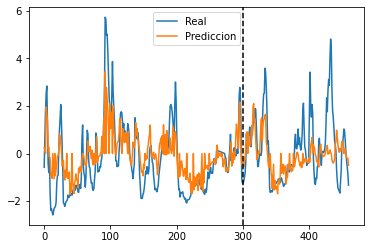

In [96]:
context = 300 
pred = 160
test(Predictor,dataset,context+pred,future=pred)

In [35]:
lista = list(range(0,10))
print (lista[-3:])

[7, 8, 9]
